<a href="https://colab.research.google.com/github/ImJongHwan/practice-ml-nlp/blob/main/sca/cve/cve_ner_with_converted_bio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [2]:
def read_data(url, filename):
  urllib.request.urlretrieve(url, filename=filename)

  f = open(filename, 'r')
  tagged_sentences = []
  sentence = []

  for line in f:
      if len(line)==0 or line.startswith('-DOCSTART') or line[0]=="\n":
          if len(sentence) > 0:
              tagged_sentences.append(sentence)
              sentence = []
          continue
      splits = line.split(' ') # 공백을 기준으로 속성을 구분한다.
      splits[-1] = re.sub(r'\n', '', splits[-1]) # 줄바꿈 표시 \n을 제거한다.
      word = splits[0].lower() # 단어들은 소문자로 바꿔서 저장한다.
      sentence.append([word, splits[-1]]) # 단어와 개체명 태깅만 기록한다.
  return tagged_sentences

In [3]:
def merge_without_dup(sentences1, sentences2):
  merged = sentences2
  for sen in sentences1:
    if sen not in sentences2:
      merged.append(sen)

  return merged

In [4]:
base_url = 'https://raw.githubusercontent.com/pinkymm/inconsistency_detection/master/dataset/ner_data/'
url_names = ['bypass', 'csrf', 'dirtra', 'dos', 'execution', 'fileinc', 'gainpre', 'httprs', 'infor', 'memc', 'overflow' ,'sqli', 'xss']

merged = []

for url_name in url_names:
  filename_test = url_name + "_test.txt"
  filename_train = url_name + "_train.txt"
  merged = merge_without_dup(merged, read_data(base_url + filename_test, filename_test))
  merged = merge_without_dup(merged, read_data(base_url + filename_train, filename_train))

In [5]:
def read_file(filename):
  f = open(filename, 'r')
  tagged_sentences = []
  sentence = []

  for line in f:
    if len(line)==0 or line.startswith('-DOCSTART') or line[0]=="\n":
        if len(sentence) > 0:
            tagged_sentences.append(sentence)
            sentence = []
        continue
    splits = line.split(' ') # 공백을 기준으로 속성을 구분한다.
    splits[-1] = re.sub(r'\n', '', splits[-1]) # 줄바꿈 표시 \n을 제거한다.
    word = splits[0].lower() # 단어들은 소문자로 바꿔서 저장한다.
    sentence.append([word, splits[-1]]) # 단어와 개체명 태깅만 기록한다.
  return tagged_sentences

In [6]:
merged = merge_without_dup(merged, read_file('converted_cve_bio.txt'))

In [7]:
print(f'전체 샘플 개수: {len(merged)}')

전체 샘플 개수: 533871


In [8]:
print('첫번째 샘플: ', merged[0])

첫번째 샘플:  [['an', 'O'], ['issue', 'O'], ['was', 'O'], ['discovered', 'O'], ['in', 'O'], ['mediawiki', 'O'], ['1.37.1.', 'O']]


In [9]:
sentences, ner_tags = [], []
for tagged_sentence in merged:
  sentence, tag_info = zip(*tagged_sentence)
  sentences.append(list(sentence))
  ner_tags.append(list(tag_info))

In [10]:
print('첫번째 샘플의 문장: ', sentences[0])
print('첫번째 샘플의 레이블: ', ner_tags[0])

첫번째 샘플의 문장:  ['an', 'issue', 'was', 'discovered', 'in', 'mediawiki', '1.37.1.']
첫번째 샘플의 레이블:  ['O', 'O', 'O', 'O', 'O', 'O', 'O']


In [11]:
print('12번째 샘플의 문장: ', sentences[12])
print('12번째 샘플의 레이블: ', ner_tags[12])

12번째 샘플의 문장:  ['importplanvalidator.php', 'in', 'the', 'fileimporter', 'extension', 'mishandles', 'the', 'check', 'for', 'edit', 'rights.']
12번째 샘플의 레이블:  ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


샘플의 최대 길이 : 950
샘플의 평균 길이 : 22.152850


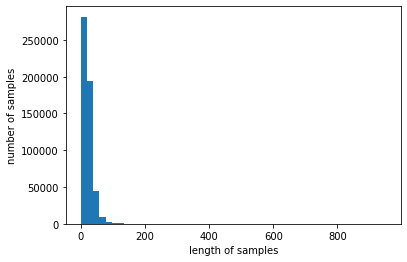

In [12]:
print('샘플의 최대 길이 : %d' % max(len(sentence) for sentence in sentences))
print('샘플의 평균 길이 : %f' % (sum(map(len, sentences))/len(sentences)))
plt.hist([len(sentence) for sentence in sentences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [13]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(sentences)

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(ner_tags)

vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1

print('단어 집합의 크기 : {}'.format(vocab_size))
print('개체명 태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 303948
개체명 태깅 정보 집합의 크기 : 7


In [14]:
X_train = src_tokenizer.texts_to_sequences(sentences)
y_train = tar_tokenizer.texts_to_sequences(ner_tags)

In [15]:
print('첫번째 샘플의 문장 :',X_train[0])
print('첫번째 샘플의 레이블 :',y_train[0])

첫번째 샘플의 문장 : [5, 35, 37, 65, 2, 2869, 9068]
첫번째 샘플의 레이블 : [1, 1, 1, 1, 1, 1, 1]


In [16]:
index_to_word = src_tokenizer.index_word
index_to_ner = tar_tokenizer.index_word

In [17]:
decoded = []
for index in X_train[0] : # 첫번째 샘플 안의 각 정수로 변환된 단어에 대해서
    decoded.append(index_to_word[index]) # 단어로 변환

print('기존 문장 : {}'.format(sentences[0]))
print('빈도수가 낮은 단어가 OOV 처리된 문장 : {}'.format(decoded))

기존 문장 : ['an', 'issue', 'was', 'discovered', 'in', 'mediawiki', '1.37.1.']
빈도수가 낮은 단어가 OOV 처리된 문장 : ['an', 'issue', 'was', 'discovered', 'in', 'mediawiki', '1.37.1.']


In [18]:
max_len = 200
X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.2, random_state=777)

In [20]:
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

In [21]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 문장의 크기 : (427096, 200)
훈련 샘플 레이블의 크기 : (427096, 200, 7)
테스트 샘플 문장의 크기 : (106775, 200)
테스트 샘플 레이블의 크기 : (106775, 200, 7)


In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, TimeDistributed
from tensorflow.keras.optimizers import Adam

In [23]:
embedding_dim = 128
hidden_units = 128

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(hidden_units, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation='softmax')))

model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=1280, epochs=1, validation_data=(X_test, y_test))

334/334 [==============================] - 4496s 13s/step - loss: 0.0275 - accuracy: 0.9390 - val_loss: 0.0086 - val_accuracy: 0.9751


In [24]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

3337/3337 [==============================] - 431s 129ms/step - loss: 0.0086 - accuracy: 0.9751

 테스트 정확도: 0.9751


In [26]:
model.save('cve.h5')